In [3]:
import numpy as np
import pandas as pd
from scipy import stats
from math import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

empirical half_lieve (s):  181


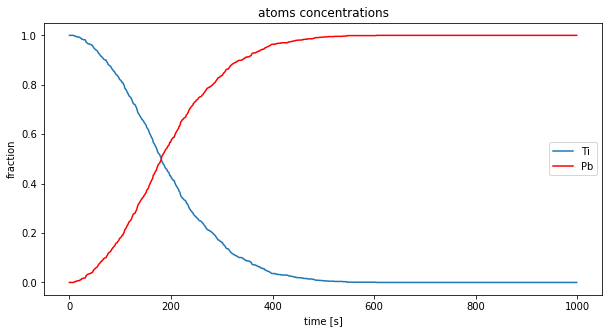

In [332]:
Ti = []
k = int(3.052 * 60)
tau = 0
for i in range(k+1):
    tau = tau + i

n = 1000
for t in range(1000):
    Ti.append(n)
    p = 1 - 2**(-t/tau)
    n = (np.random.rand(n) > p).sum()
    
Ti = np.array(Ti)
Pb = 1000 - Ti
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(range(1000), Ti/1000, label = 'Ti')
ax.plot(range(1000), Pb/1000 , c = 'r', label = 'Pb')
ax.set_title('atoms concentrations')
ax.set_xlabel('time [s]')
ax.set_ylabel('fraction')
ax.legend(loc = 'best')
print("empirical half_lieve (s): ", np.abs(Ti - 500).argmin())

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [261]:
a0 = 5.291777721092*10**(-11)
Z = 79
e0 = 8.85418781762*10**(-12)
e = 1.602176634*10**(-19)

In [262]:
n = 10000000

b1 = np.random.randn(n)*a0/100
b2 = np.random.randn(n)*a0/100
def tanhalff(b):
    return 79*e/(2*pi*e0*7.7*10**6*b)

theta1 = 2*np.arctan(tanhalff(b1))
theta2 = 2*np.arctan(tanhalff(b2))

In [264]:
mask1 = (np.abs(theta1)<pi/2)
mask2 = (np.abs(theta2)<pi/2)
print('fraction of particles that "bounce back":',1 - (mask1*mask2).sum()/n)

fraction of particles that "bounce back": 0.08735630000000005


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

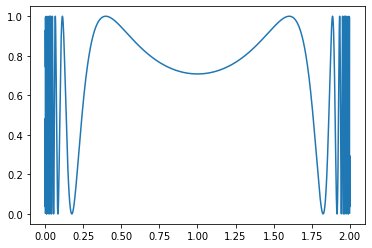

In [18]:
def f(x):
    return np.sin(1/(x*(2-x)))**2

plt.plot(np.linspace(0.000001,2-0.000001,10000),f(np.linspace(0.000001,2-0.000001,10000)))

In [35]:
hmvalues = []
    
for asd in range(1000):
    i = 0
    simn = np.random.rand(10000)*2
    for a in simn:
        if np.random.rand() < f(a):
            i = i + 1
    hmvalues.append(2*i/10000)

In [64]:
meanvalues = []
    
for asd in range(1000):
    
    simn = np.random.rand(10000)*2
    meanvalues.append(2*f(simn).sum()/10000)

In [78]:
#i try to compute the classic integration
classicvalues = []
    
for asd in range(1000):
    
    simn = np.linspace(0.0001,1.9999,10000) + 0.0001*np.random.rand()
    classicvalues.append(2*f(simn).sum()/10000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a30a49940>,
      dtype=object)

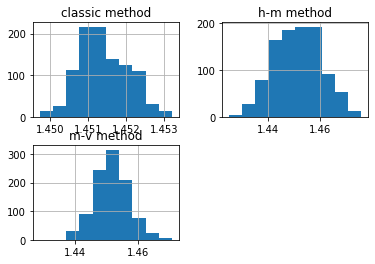

In [79]:
#we can see how the hit miss mathod is less accurate with respect to the mean value method.
#The order of magnitude is the same
#The deterministic rule of ccomputational integration is is this case better than the stochastic methods
pd.DataFrame(np.array([hmvalues, meanvalues, classicvalues]).T, columns = ["h-m method", "m-v method", "classic method"]).hist()

4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [136]:
#2-d sphere
d = 2
2**d*(((np.random.rand(d,1000000)*2 - 1)**2).sum(axis = 0) < 1).sum()/1000000

3.141696

In [137]:
#10-d sphere
d = 10
2**d*(((np.random.rand(10,1000000)*2 - 1)**2).sum(axis = 0) < 1).sum()/1000000

2.54976

5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [267]:
def f(x):
    return 1/((np.exp(x) + 1)*np.sqrt(x))
def w(x):
    return 1/np.sqrt(x)

In [270]:
#rn is the sample drawn by the PDF 1/sqrt(x) normalized
rn = np.random.rand(1000000)**2
2 * (f(rn)/w(rn)).sum()/1000000

0.8389611401091527